このコードでは、create_dataset_city&AQI_2.ipynbで作成したcsvファイルから抽出した目的変数と説明変数から、自己回帰モデルであるARIMAとSARIMAモデル、ARIMAXモデルとSARIMAXモデルの四つを用いて将来の値を予測するという作業を行う。

前提として、

*  Data_preprocessing_1とData_preprocessing_city&AQI_2、Data_feature&Missing_value_imputation_3を動かし、訓練・テストデータとして用いるデータがcsvとして保存されていること

が条件となる。

**注意事項**

※ 作成者はGoogle drive内で作業をしていると同時に、ゼミというフォルダーの中の公開ソースというフォルダーで作業していることからpathの変更は必要不可欠である

# 初期設定

都市ごとの大気汚染物質データを読み取ると同時に、パラメータや結果、予測値を保存するデータフレームを作成する作業などを行う


In [1]:
#Google driveに接続
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#インストールするものや、ライブラリーをインポートする
! pip install japanize-matplotlib
import pandas as pd
import numpy as np
import os
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

#自己回帰モデルを使用するためのライブラリ
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=443b046ea3640e1cea5a2e018057913d200f7d3bd1dea0bd92ad872b22047f62
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


In [3]:
! pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.2 MB/s eta 0:00:00


In [4]:
#自己回帰モデルを使用するためのライブラリ
import pmdarima as pm
from pmdarima import datasets
from pmdarima import utils
from pmdarima import arima
from pmdarima import model_selection

In [5]:
#csvファイルを読み込み
working_dir = "/content/drive/MyDrive/ゼミ/公開ソース"
path = f'{working_dir}/data/traninig_validation_test_data'
city_lists = ["Tokyo","Delhi"]

for city_name in city_lists:
  city_df = pd.read_csv(f'{path}/{city_name}_paper.csv',index_col=0,parse_dates=True)
  exec("{}=city_df".format(city_name))

In [6]:
#確認
Tokyo
# Delhi

,precipitation,temperature,wind-speed,pressure,humidity,co,so2,pm25,pm10,o3,no2,AQI_total
Date,,,,,,,,,,,,
2019-01-01,0.0,5.3,2.3,1019.6,54,0.34,0.0015,38.0,10.0,0.0168,0.0139,95.0
2019-01-02,0.0,6.2,2.9,1017.7,47,0.34,0.0015,17.0,5.0,0.0241,0.0084,54.0
2019-01-03,0.0,4.9,3.1,1020.2,49,0.23,0.0015,17.0,5.0,0.0248,0.0084,54.0
2019-01-04,0.0,5.1,2.0,1023.0,59,0.45,0.0029,34.0,9.0,0.0184,0.0176,87.0
2019-01-05,0.0,7.4,2.1,1010.6,52,0.45,0.0015,50.0,11.0,0.0160,0.0213,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-30,0.0,16.9,2.0,1017.5,62,0.34,0.0015,25.0,8.0,0.0224,0.0121,70.0
2023-10-31,0.0,17.2,1.6,1019.7,72,0.45,0.0029,42.0,13.0,0.0160,0.0195,104.0
2023-11-01,0.0,18.0,2.3,1016.8,72,0.45,0.0029,53.0,16.0,0.0248,0.0167,126.0


In [7]:
#1日ごとのデータを1週間単位に変換する
#※自己回帰系は365周期での予測に大幅な時間を要するため、週単位の平均値を予測する
Tokyo = Tokyo.resample("W").mean()
Delhi = Delhi.resample("W").mean()

In [8]:
#目的変数を抽出するためのリスト
elements = ["AQI_total","pm25","pm10","co","no2","so2","o3"]
# elements = ["AQI_total"]

In [9]:
#予測した値を保持するデータフレーム
df_pred = pd.DataFrame(index=[Tokyo.index])[-52:]

In [10]:
#パラメータを保持するためのデータフレーム作成(説明変数ないモデルで使用)
xnon_df_para = pd.DataFrame(index =elements)

In [11]:
#パラメータを保持するためのデータフレーム作成(説明変数を使用したモデルで使う)
#csvデータを読み取る際に使用したリストを再度使用(city_lists)
#※説明変数を用いる予測では、地域ごとに説明変数が使えるものが限られているため、TokyoとDelhiでデータフレームを分けて作成する

lists_dataframe = [Tokyo,Delhi]
materials = []
for number, city in enumerate(lists_dataframe):
  city_para = city_lists[number]+"_para_x"
  materials = []
  for x in elements:
    elements_drop = city.drop(columns=x)
    for column_name, number in elements_drop.iteritems():
      materials.append(f"{x}_{column_name}")
  x_df_para = pd.DataFrame(index=materials)
  exec("{}=x_df_para".format(city_para))

<ipython-input-11-af0ade697511>:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, number in elements_drop.iteritems():
<ipython-input-11-af0ade697511>:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, number in elements_drop.iteritems():
<ipython-input-11-af0ade697511>:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, number in elements_drop.iteritems():
<ipython-input-11-af0ade697511>:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, number in elements_drop.iteritems():
<ipython-input-11-af0ade697511>:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, number in elements_drop.iteritems():
<ipython-input-11-af0ade697511>:12: Futu

In [12]:
#説明変数ありのパラメータデータフレームの確認
Tokyo_para_x

""
AQI_total_precipitation
AQI_total_temperature
AQI_total_wind-speed
AQI_total_pressure
AQI_total_humidity
...
o3_so2
o3_pm25
o3_pm10
o3_no2


In [13]:
#説明変数ありのパラメータデータフレームの確認
Delhi_para_x

""
AQI_total_temperature
AQI_total_precipitation
AQI_total_humidity
AQI_total_pressure
AQI_total_co
...
o3_so2
o3_pm25
o3_pm10
o3_no2


In [14]:
#MAPE値を算出するための関数
def mape(predict, observed):
  absolute_diff_percentage =  abs( (predict - observed) / observed)
  sum_abs_diff = sum(absolute_diff_percentage)
  mape = sum_abs_diff / len(predict)
  return mape

In [15]:
#mape値をデータフレームに入れるためのデータフレーム作成
df_results_nonx = pd.DataFrame(columns=["ARIMA","SARIMA"])
df_results_x = pd.DataFrame(columns=["ARIMAX","SARIMAX"])

# 予測モデル構築と予測値の算出

# ARIMA


In [16]:
#ARIMAモデルのパラメータ構築関数
def arima_parameta(df,city_name,elements):
  para_row = []
  for column_name, item in df[elements].iteritems():
    train =df[column_name][:-52]
    test =df[column_name][-52:]
    arima_model = pm.auto_arima(train, seasonal=False,n_jobs=-1,maxiter=10)
    optimal_order = arima_model.get_params()['order']
    para_row.append(optimal_order)
  xnon_df_para[f"ARIMA_{city_name}"] = para_row
  return xnon_df_para

In [17]:
#上記の関数を動かす
%%time
arima_parameta(Tokyo,"Tokyo",elements)
arima_parameta(Delhi,"Delhi",elements)

<ipython-input-16-6fa94586159e>:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, item in df[elements].iteritems():
/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
/usr/local/lib/python3.10/dist-packages/pmda

CPU times: user 41.4 s, sys: 37.3 s, total: 1min 18s
Wall time: 1min 9s


,ARIMA_Tokyo,ARIMA_Delhi
AQI_total,"(0, 1, 1)","(1, 0, 3)"
pm25,"(0, 1, 1)","(3, 0, 0)"
pm10,"(2, 0, 0)","(3, 0, 0)"
co,"(3, 0, 0)","(3, 0, 2)"
no2,"(1, 0, 2)","(5, 0, 0)"
so2,"(0, 1, 2)","(0, 1, 0)"
o3,"(2, 0, 0)","(1, 0, 1)"


In [18]:
#ARIMAモデルのパラメータを元に予測する関数
def arima_construction(df,City_name,elements,parameta):
  for column_name, number in df[elements].iteritems():
    train =df[column_name][:-52]
    test =df[column_name][-52:]
    arima_model = sm.tsa.ARIMA(train,order=parameta[f"ARIMA_{City_name}"].loc[column_name])
    results = arima_model.fit()
    bestpred = results.predict(start="2022-11-13",end="2023-11-05")
    df_pred[f"{City_name}_{column_name}_ARIMA"] = bestpred.values
    mape_df = str(str(round(mape(bestpred, test)*100,2))+"%")
    df_results_nonx.at[f"{City_name}_{column_name}","ARIMA"] = mape_df
  return


In [19]:
%%time
arima_construction(Tokyo,"Tokyo",elements,xnon_df_para)
arima_construction(Delhi,"Delhi",elements,xnon_df_para)

<ipython-input-18-7bb402f38b3e>:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, number in df[elements].iteritems():
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-18-7bb402f38b3e>:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, number in df[elements].iteritems():
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


CPU times: user 4.68 s, sys: 3.65 s, total: 8.33 s
Wall time: 4.44 s


In [20]:
#MAPE値の確認
df_results_nonx

,ARIMA,SARIMA
Tokyo_AQI_total,15.5%,NaN
Tokyo_pm25,20.41%,NaN
Tokyo_pm10,25.21%,NaN
Tokyo_co,15.12%,NaN
Tokyo_no2,38.27%,NaN
Tokyo_so2,9.49%,NaN
Tokyo_o3,33.68%,NaN
Delhi_AQI_total,21.07%,NaN
Delhi_pm25,43.33%,NaN
Delhi_pm10,46.25%,NaN


In [21]:
#予測値の確認
df_pred

,Tokyo_AQI_total_ARIMA,Tokyo_pm25_ARIMA,Tokyo_pm10_ARIMA,Tokyo_co_ARIMA,Tokyo_no2_ARIMA,Tokyo_so2_ARIMA,Tokyo_o3_ARIMA,Delhi_AQI_total_ARIMA,Delhi_pm25_ARIMA,Delhi_pm10_ARIMA,Delhi_co_ARIMA,Delhi_no2_ARIMA,Delhi_so2_ARIMA,Delhi_o3_ARIMA
Date,,,,,,,,,,,,,,
2022-11-13,89.695936,35.047259,12.051421,0.380380,0.013161,0.001639,0.019303,306.185744,249.203498,212.489752,1.367186,0.023525,0.004657,0.005529
2022-11-20,89.695936,35.047259,12.570750,0.374410,0.013221,0.001629,0.019893,305.013197,243.805169,205.498331,1.439588,0.022824,0.004657,0.005843
2022-11-27,89.695936,35.047259,12.967053,0.372351,0.013202,0.001629,0.020218,305.323332,243.517715,198.892045,1.386533,0.022002,0.004657,0.006124
2022-12-04,89.695936,35.047259,13.166702,0.371237,0.013185,0.001629,0.020588,295.344689,235.836069,187.308401,1.260134,0.022152,0.004657,0.006376
2022-12-11,89.695936,35.047259,13.294905,0.369319,0.013169,0.001629,0.020872,286.624891,230.726786,179.786206,1.258949,0.021491,0.004657,0.006602
2022-12-18,89.695936,35.047259,13.365983,0.367969,0.013155,0.001629,0.021138,279.005130,226.515943,173.159453,1.288049,0.020581,0.004657,0.006804
2022-12-25,89.695936,35.047259,13.408982,0.366744,0.013142,0.001629,0.021362,272.346632,222.127521,167.239619,1.222279,0.020064,0.004657,0.006986
2023-01-01,89.695936,35.047259,13.433665,0.365607,0.013130,0.001629,0.021561,266.528130,218.190167,162.283588,1.166631,0.019535,0.004657,0.007149
2023-01-08,89.695936,35.047259,13.448285,0.364625,0.013119,0.001629,0.021733,261.443656,214.607143,158.020805,1.186104,0.018887,0.004657,0.007294


# ARIMAX

In [22]:
#ARIMAXモデルのパラメータ構築関数
def arimax_parameta(df,City_name,elements,parameta_df):
  para_row = []
  for column_name, item in df[elements].iteritems():
    df_target = df[column_name]
    df_drop = df.drop(columns=column_name)
    for column_name_e, number in df_drop.iteritems():
      train =df_target[:-52]
      test =df_target[-52:]
      exog_train = df_drop[column_name_e][:-52]
      arima_model = pm.auto_arima(train, exogenous=exog_train,seasonal=False,n_jobs=-1,maxiter=10)
      optimal_order = arima_model.get_params()['order']
      para_row.append(optimal_order)
  parameta_df[f"ARIMAX_{City_name}"] = para_row
  return parameta_df


In [23]:
#作成した関数を動かす
#※ 時間がかかる(10分ほど)
%%time
arimax_parameta(Tokyo,"Tokyo",elements,Tokyo_para_x)
arimax_parameta(Delhi,"Delhi",elements,Delhi_para_x)

<ipython-input-22-e667125a861b>:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, item in df[elements].iteritems():
<ipython-input-22-e667125a861b>:6: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name_e, number in df_drop.iteritems():
/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be f

CPU times: user 6min 31s, sys: 5min 15s, total: 11min 46s
Wall time: 7min 5s


,ARIMAX_Delhi
AQI_total_temperature,"(1, 0, 3)"
AQI_total_precipitation,"(1, 0, 3)"
AQI_total_humidity,"(1, 0, 3)"
AQI_total_pressure,"(1, 0, 3)"
AQI_total_co,"(1, 0, 3)"
...,...
o3_so2,"(1, 0, 1)"
o3_pm25,"(1, 0, 1)"
o3_pm10,"(1, 0, 1)"
o3_no2,"(1, 0, 1)"


In [24]:
#ARIMAXモデルのパラメータを元に予測する関数
def arimax_construction(df,City_name,parameta):
  for column_name, number in df[elements].iteritems():
    df_target = df[column_name]
    df_drop = df.drop(columns=column_name)
    #ネストすることにより、指定している値以外の値を読み取ることができる。
    for column_name_e, number in df_drop.iteritems():
      train =df_target[:-52]
      test =df_target[-52:]
      exog_train = df_drop[column_name_e][:-52]
      exog_test =df_drop[column_name_e][-52:]
      arimax_model = sm.tsa.SARIMAX(train,exog=exog_train,order=parameta[f"ARIMAX_{City_name}"].loc[f"{column_name}_{column_name_e}"])
      results = arimax_model.fit()
      bestpred = results.predict(start="2022-11-13",end="2023-11-05",exog=exog_test,dynamic= True)
      df_pred[f"{City_name}_{column_name}_{column_name_e}_ARIMAX"] = bestpred.values
      mape_df = str(str(round(mape(bestpred, test)*100,2))+"%")
      df_results_x.at[f"{City_name}_{column_name}_{column_name_e}","ARIMAX"] = mape_df
  return


In [25]:
%%time
arimax_construction(Tokyo,"Tokyo",Tokyo_para_x)
arimax_construction(Delhi,"Delhi",Delhi_para_x)

<ipython-input-24-d73d1a7514d5>:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, number in df[elements].iteritems():
<ipython-input-24-d73d1a7514d5>:6: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name_e, number in df_drop.iteritems():
<ipython-input-24-d73d1a7514d5>:6: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name_e, number in df_drop.iteritems():
<ipython-input-24-d73d1a7514d5>:6: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name_e, number in df_drop.iteritems():
<ipython-input-24-d73d1a7514d5>:6: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name_e, number in df_drop.iteritems():
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model

CPU times: user 55.5 s, sys: 46.7 s, total: 1min 42s
Wall time: 1min 4s


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-24-d73d1a7514d5>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pred[f"{City_name}_{column_name}_{column_name_e}_ARIMAX"] = bestpred.values


In [26]:
#MAPE値の確認
df_results_x

,ARIMAX,SARIMAX
Tokyo_AQI_total_precipitation,15.95%,NaN
Tokyo_AQI_total_temperature,15.54%,NaN
Tokyo_AQI_total_wind-speed,15.93%,NaN
Tokyo_AQI_total_pressure,15.48%,NaN
Tokyo_AQI_total_humidity,16.35%,NaN
...,...,...
Delhi_o3_so2,30.4%,NaN
Delhi_o3_pm25,72.86%,NaN
Delhi_o3_pm10,80.7%,NaN
Delhi_o3_no2,86.35%,NaN


In [27]:
#予測値の確認
df_pred

,Tokyo_AQI_total_ARIMA,Tokyo_pm25_ARIMA,Tokyo_pm10_ARIMA,Tokyo_co_ARIMA,Tokyo_no2_ARIMA,Tokyo_so2_ARIMA,Tokyo_o3_ARIMA,Delhi_AQI_total_ARIMA,Delhi_pm25_ARIMA,Delhi_pm10_ARIMA,...,Delhi_o3_temperature_ARIMAX,Delhi_o3_precipitation_ARIMAX,Delhi_o3_humidity_ARIMAX,Delhi_o3_pressure_ARIMAX,Delhi_o3_co_ARIMAX,Delhi_o3_so2_ARIMAX,Delhi_o3_pm25_ARIMAX,Delhi_o3_pm10_ARIMAX,Delhi_o3_no2_ARIMAX,Delhi_o3_AQI_total_ARIMAX
Date,,,,,,,,,,,,,,,,,,,,,
2022-11-13,89.695936,35.047259,12.051421,0.380380,0.013161,0.001639,0.019303,306.185744,249.203498,212.489752,...,0.005245,0.005251,0.004489,0.005501,0.005475,0.005343,0.004564,0.004775,0.004856,0.004366
2022-11-20,89.695936,35.047259,12.570750,0.374410,0.013221,0.001629,0.019893,305.013197,243.805169,205.498331,...,0.004538,0.005115,0.004077,0.005779,0.005351,0.006076,0.004221,0.004438,0.004303,0.003991
2022-11-27,89.695936,35.047259,12.967053,0.372351,0.013202,0.001629,0.020218,305.323332,243.517715,198.892045,...,0.004153,0.004983,0.003795,0.006018,0.005362,0.006529,0.003968,0.004035,0.003698,0.003833
2022-12-04,89.695936,35.047259,13.166702,0.371237,0.013185,0.001629,0.020588,295.344689,235.836069,187.308401,...,0.004059,0.004855,0.003806,0.006255,0.004699,0.005682,0.003852,0.003519,0.002974,0.004027
2022-12-11,89.695936,35.047259,13.294905,0.369319,0.013169,0.001629,0.020872,286.624891,230.726786,179.786206,...,0.004182,0.004729,0.003525,0.006464,0.005185,0.005263,0.003530,0.003321,0.002999,0.003599
2022-12-18,89.695936,35.047259,13.365983,0.367969,0.013155,0.001629,0.021138,279.005130,226.515943,173.159453,...,0.004037,0.004607,0.003199,0.006643,0.005349,0.005148,0.003258,0.003114,0.002724,0.003282
2022-12-25,89.695936,35.047259,13.408982,0.366744,0.013142,0.001629,0.021362,272.346632,222.127521,167.239619,...,0.003190,0.004488,0.003414,0.006803,0.004914,0.004379,0.003192,0.002654,0.002468,0.003522
2023-01-01,89.695936,35.047259,13.433665,0.365607,0.013130,0.001629,0.021561,266.528130,218.190167,162.283588,...,0.003505,0.004372,0.003147,0.006978,0.004976,0.004876,0.002944,0.002511,0.002408,0.003214
2023-01-08,89.695936,35.047259,13.448285,0.364625,0.013119,0.001629,0.021733,261.443656,214.607143,158.020805,...,0.002588,0.004260,0.003141,0.007094,0.004900,0.005788,0.002885,0.002087,0.002177,0.003419


# SARIMA


In [28]:
def sarima_parameta(df,City_name,elements):
  row_order = []
  row_order_s = []
  for column_name, item in df[elements].iteritems():
    train =df[column_name][:-52]
    test =df[column_name][-52:]
    sarima_model = pm.auto_arima(train, seasonal=True,m=52,n_jobs=-1,maxiter=10)
    order = sarima_model.get_params()['order']
    seasonal_order = sarima_model.get_params()['seasonal_order']
    row_order.append(order)
    row_order_s.append(seasonal_order)


  xnon_df_para[f"SARIMA_{City_name}_order"] = row_order
  xnon_df_para[f"SARIMA_{City_name}_order_s"] = row_order_s
  return


In [29]:
%%time
sarima_parameta(Tokyo,"Tokyo",elements)
sarima_parameta(Delhi,"Delhi",elements)

<ipython-input-28-898feac74084>:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, item in df[elements].iteritems():
/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
/usr/local/lib/python3.10/dist-packages/pmda

CPU times: user 32min 57s, sys: 16min 56s, total: 49min 54s
Wall time: 29min 54s


In [30]:
#SARIMAモデルでパラメータを元に予測する関数
def sarima_construction(df,city_name,parameta):
  for column_name, number in df[elements].iteritems():
    train =df[column_name][:-52]
    test =df[column_name][-52:]
    ##ここ改良必要
    sarima_model = sm.tsa.SARIMAX(train,order=parameta[f"SARIMA_{city_name}_order"].loc[column_name],seasonal_order=(parameta[f"SARIMA_{city_name}_order_s"].loc[column_name]),enforce_invertibility = False, enforce_stationarity = False)
    results = sarima_model.fit()
    bestpred = results.predict(start="2022-11-13",end="2023-11-05")
    df_pred[f"{city_name}_{column_name}_SARIMA"] = bestpred.values
    mape_df = str(str(round(mape(bestpred, test)*100,2))+"%")
    df_results_nonx.at[f"{city_name}_{column_name}","SARIMA"] = mape_df
  return

In [31]:
%%time
sarima_construction(Tokyo,"Tokyo",xnon_df_para)
sarima_construction(Delhi,"Delhi",xnon_df_para)

<ipython-input-30-f610316d1d91>:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, number in df[elements].iteritems():
<ipython-input-30-f610316d1d91>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pred[f"{city_name}_{column_name}_SARIMA"] = bestpred.values
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-30-f610316d1d91>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

CPU times: user 1min 12s, sys: 19.1 s, total: 1min 31s
Wall time: 1min 5s


<ipython-input-30-f610316d1d91>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pred[f"{city_name}_{column_name}_SARIMA"] = bestpred.values


In [32]:
#MAPE値の確認
df_results_nonx

,ARIMA,SARIMA
Tokyo_AQI_total,15.5%,16.17%
Tokyo_pm25,20.41%,20.41%
Tokyo_pm10,25.21%,23.46%
Tokyo_co,15.12%,12.37%
Tokyo_no2,38.27%,21.68%
Tokyo_so2,9.49%,9.49%
Tokyo_o3,33.68%,38.79%
Delhi_AQI_total,21.07%,21.98%
Delhi_pm25,43.33%,31.42%
Delhi_pm10,46.25%,31.77%


In [33]:
#保存した予測値のカラムを全て表示
df_pred.columns

Index(['Tokyo_AQI_total_ARIMA', 'Tokyo_pm25_ARIMA', 'Tokyo_pm10_ARIMA',
       'Tokyo_co_ARIMA', 'Tokyo_no2_ARIMA', 'Tokyo_so2_ARIMA',
       'Tokyo_o3_ARIMA', 'Delhi_AQI_total_ARIMA', 'Delhi_pm25_ARIMA',
       'Delhi_pm10_ARIMA',
       ...
       'Tokyo_no2_SARIMA', 'Tokyo_so2_SARIMA', 'Tokyo_o3_SARIMA',
       'Delhi_AQI_total_SARIMA', 'Delhi_pm25_SARIMA', 'Delhi_pm10_SARIMA',
       'Delhi_co_SARIMA', 'Delhi_no2_SARIMA', 'Delhi_so2_SARIMA',
       'Delhi_o3_SARIMA'],
      dtype='object', length=175)

# 各データフレームの保存

## パラメータの保存

In [ ]:
#保存先を指定
path_para = f"{working_dir}/result/parameta"

In [ ]:
#説明変数なし
xnon_df_para.to_csv(f"{path_para}/not_explanatory_variables.csv")

In [ ]:
#説明変数あり(SARIMAXモデルなし)
Tokyo_para_x.to_csv(f"{path_para}/Tokyo_explanatory_variables_ARIMAX.csv")
Delhi_para_x.to_csv(f"{path_para}/Delhi_explanatory_variables_ARIMAX.csv")

## MAPE値の保存

In [42]:
#保存先を指定
path_mape = f"{working_dir}/result/data/MAPE/"

In [ ]:
#説明変数なしのARIMAとSARIMAモデルのMAPE値を保存
df_results_nonx.to_csv(f"{path_mape}/自己回帰_no_explanatory_variables.csv")

In [ ]:
#説明変数ありのARIMAXのMAPE値を保存
df_results_x.to_csv(f"{path_mape}/自己回帰_explanatory_variables_ARIMAX.csv")

## 予測値の保存

In [ ]:
df_pred

,Tokyo_AQI_total_ARIMA,Tokyo_pm25_ARIMA,Tokyo_pm10_ARIMA,Tokyo_co_ARIMA,Tokyo_no2_ARIMA,Tokyo_so2_ARIMA,Tokyo_o3_ARIMA,Delhi_AQI_total_ARIMA,Delhi_pm25_ARIMA,Delhi_pm10_ARIMA,...,Tokyo_no2_SARIMA,Tokyo_so2_SARIMA,Tokyo_o3_SARIMA,Delhi_AQI_total_SARIMA,Delhi_pm25_SARIMA,Delhi_pm10_SARIMA,Delhi_co_SARIMA,Delhi_no2_SARIMA,Delhi_so2_SARIMA,Delhi_o3_SARIMA
Date,,,,,,,,,,,,,,,,,,,,,
2022-11-13,89.695936,35.047259,12.051421,0.380380,0.013161,0.001639,0.019303,306.185744,249.203498,212.489752,...,0.012787,0.001639,0.018201,326.125045,359.395312,260.149589,1.252391,0.023288,0.004657,0.005033
2022-11-20,89.695936,35.047259,12.570750,0.374410,0.013221,0.001629,0.019893,305.013197,243.805169,205.498331,...,0.012803,0.001629,0.018367,304.427066,300.009304,209.394177,1.241478,0.022592,0.004657,0.004967
2022-11-27,89.695936,35.047259,12.967053,0.372351,0.013202,0.001629,0.020218,305.323332,243.517715,198.892045,...,0.012694,0.001629,0.018011,307.799494,275.109286,223.002284,1.230660,0.022329,0.004657,0.004902
2022-12-04,89.695936,35.047259,13.166702,0.371237,0.013185,0.001629,0.020588,295.344689,235.836069,187.308401,...,0.012586,0.001629,0.017915,302.251081,276.674797,205.301104,1.219936,0.022629,0.004657,0.004838
2022-12-11,89.695936,35.047259,13.294905,0.369319,0.013169,0.001629,0.020872,286.624891,230.726786,179.786206,...,0.012479,0.001629,0.017694,271.208283,229.972216,173.057364,1.209306,0.022295,0.004657,0.004774
2022-12-18,89.695936,35.047259,13.365983,0.367969,0.013155,0.001629,0.021138,279.005130,226.515943,173.159453,...,0.012373,0.001629,0.017537,285.550372,250.767809,181.845786,1.198769,0.021893,0.004657,0.004712
2022-12-25,89.695936,35.047259,13.408982,0.366744,0.013142,0.001629,0.021362,272.346632,222.127521,167.239619,...,0.012268,0.001629,0.017351,336.322950,347.361375,242.451364,1.188323,0.021714,0.004657,0.004650
2023-01-01,89.695936,35.047259,13.433665,0.365607,0.013130,0.001629,0.021561,266.528130,218.190167,162.283588,...,0.012164,0.001629,0.017182,284.468240,250.231451,173.119430,1.177968,0.021447,0.004657,0.004589
2023-01-08,89.695936,35.047259,13.448285,0.364625,0.013119,0.001629,0.021733,261.443656,214.607143,158.020805,...,0.012061,0.001629,0.017007,277.497653,235.000811,161.274045,1.167704,0.021110,0.004657,0.004529


In [41]:
#予測値のデータフレームを保存する場所を指定
pred_path = f"{working_dir}/result/data/自己回帰"

In [ ]:
#予測値のデータフレームを保存
df_pred.to_csv(f"{pred_path}/ARIMA_SARIMA_ARIMAX.csv")

## グラフ作成

論文で貼り付けたグラフである、ARIMA・SARIMAの二つの時系列グラフを描画する
※ ARIMAXとSARIMAXのグラフも描画すると大量の線でグラフが見づらくなるため、この二つのモデルのみ描画している

In [ ]:
#グラフの保存先を指定
path_graph = f"{working_dir}/result/graph/自己回帰"

In [ ]:
def create_graph(pred_df,df,city_name,elements):
  city_names = [col for col in pred_df.columns if city_name in col]
  arima_sarima = [col for col in city_names if "ARIMAX" not in col]
  pred_df = pred_df[arima_sarima]
  test=df[elements][-52:]


  for element in elements:
    city_pred = [col for col in pred_df.columns if element in col]
    for column_name, number in pred_df[city_pred].iteritems():
      test[column_name] = pred_df[column_name].values

  rcParams['figure.figsize'] = 15, 6

  for target_element in elements:
    element_values = [col for col in test.columns if target_element in col]
    element_df = test[element_values]
    plt.title(f"{city_name}(2022/11/13~2023/11/5){target_element}_AutoRegressive")
    plt.plot(element_df.iloc[:, 0],linewidth=3,label=element_values[0])
    for x in range(1,len(element_df.columns),1):
      plt.plot(element_df.iloc[:, x],linewidth=2,label=element_values[x])
    plt.xlabel('Date')
    plt.ylabel("Values")
    plt.legend()
    plt.savefig(f'{path_graph}/{city_name}_{target_element}_AutoRegressive_week.png')
    plt.show()





<ipython-input-74-122c6f929ed8>:10: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, number in pred_df[city_pred].iteritems():
<ipython-input-74-122c6f929ed8>:10: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, number in pred_df[city_pred].iteritems():
<ipython-input-74-122c6f929ed8>:10: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, number in pred_df[city_pred].iteritems():
<ipython-input-74-122c6f929ed8>:10: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, number in pred_df[city_pred].iteritems():
<ipython-input-74-122c6f929ed8>:10: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, number in pred_df[city_pred].iteritems():
<ipython-input-

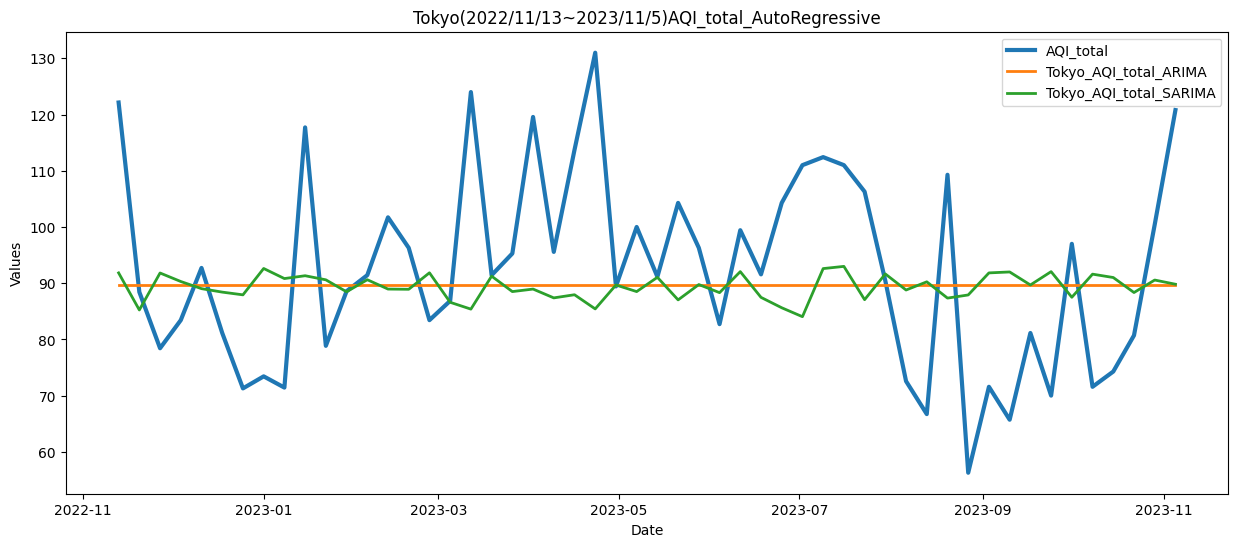

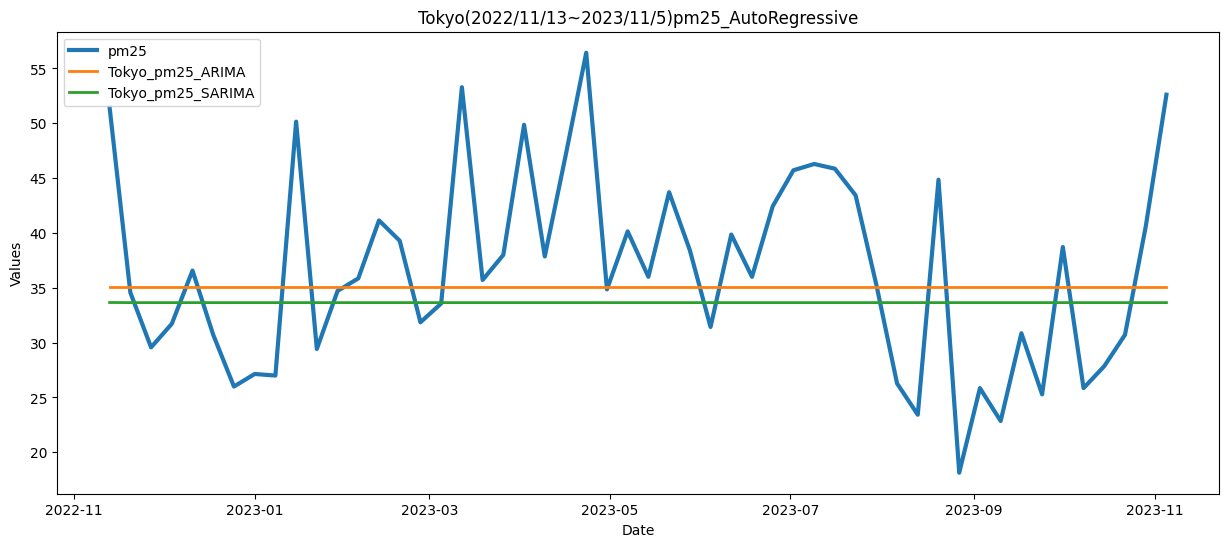

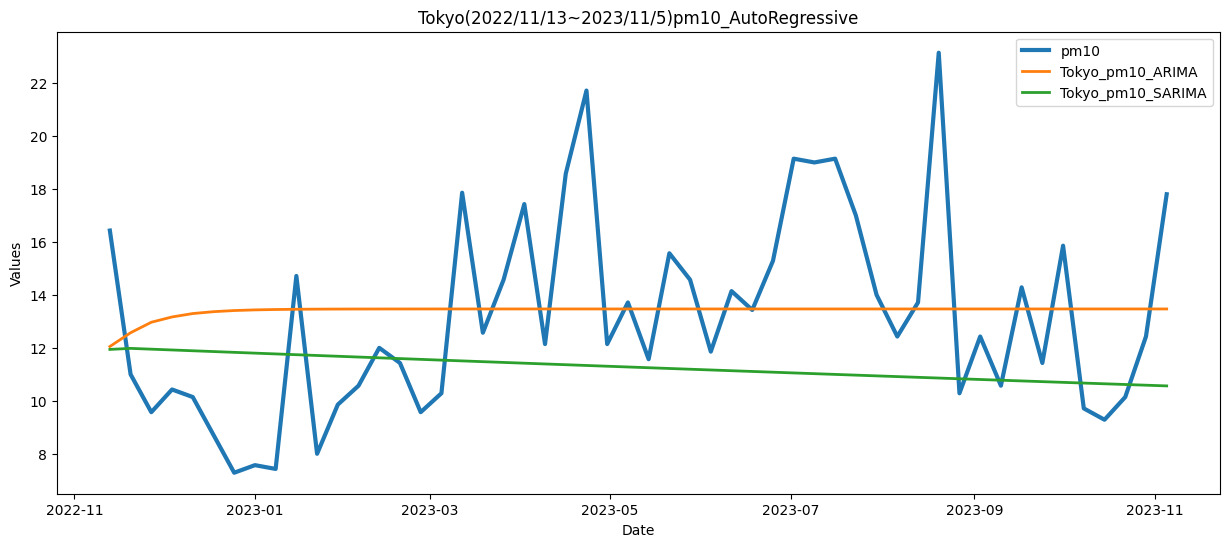

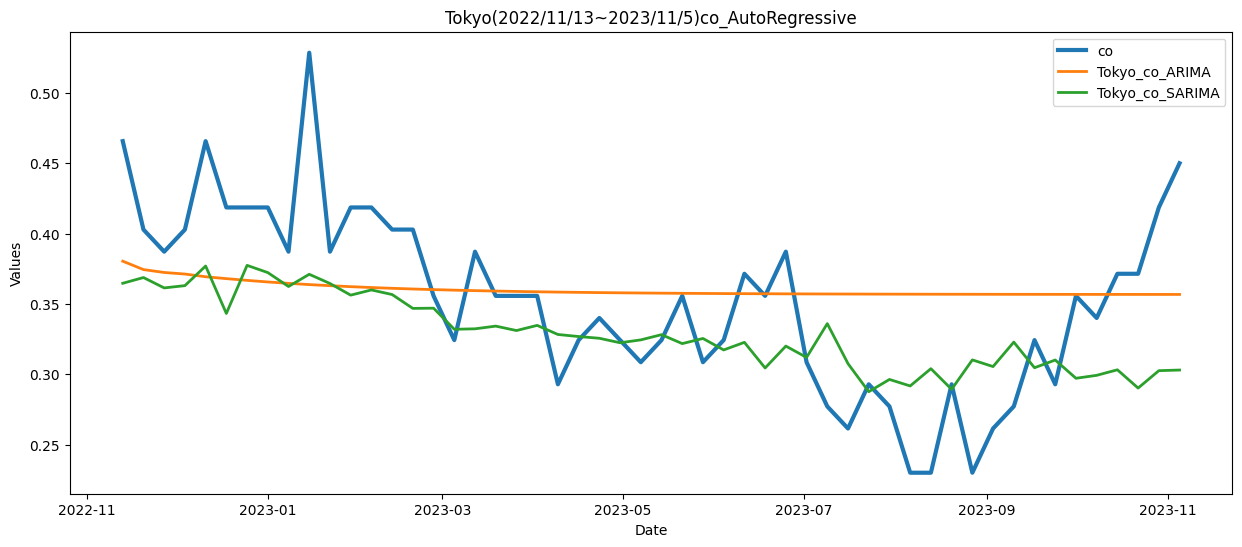

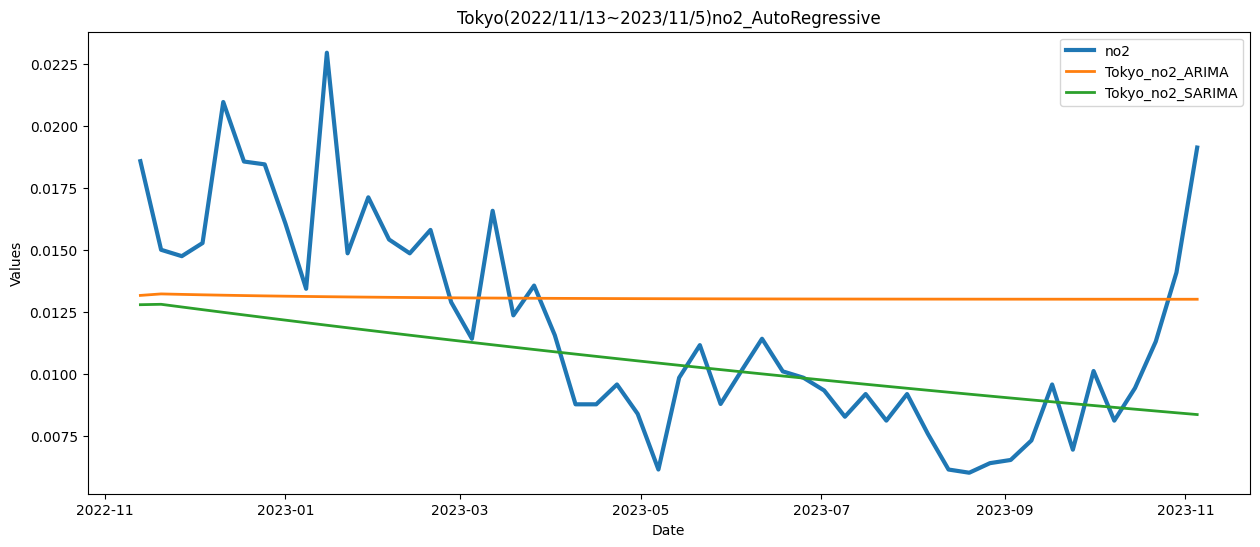

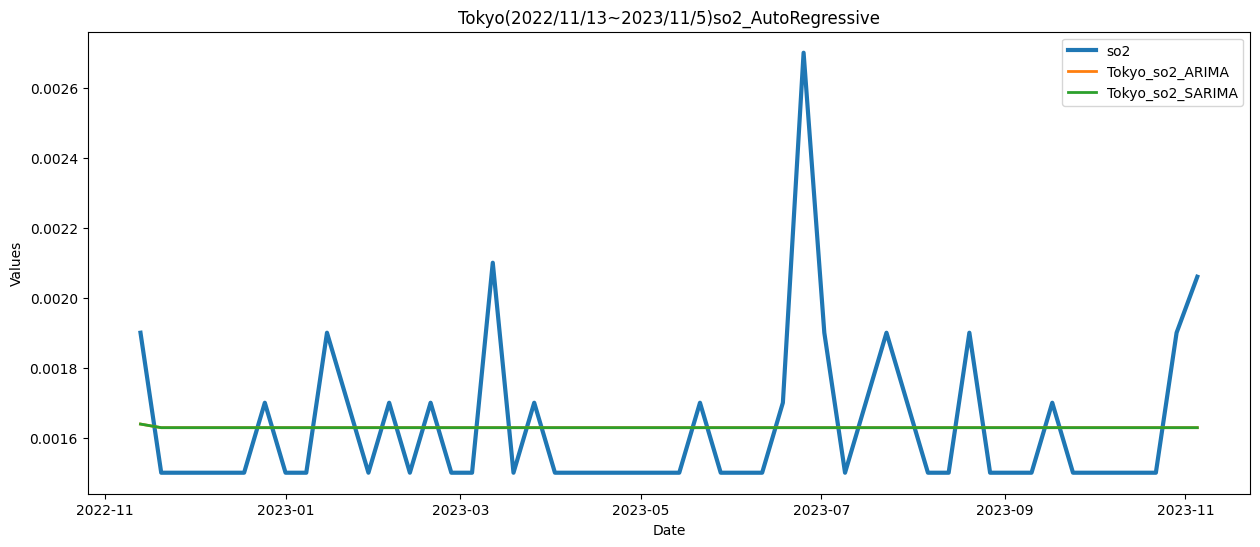

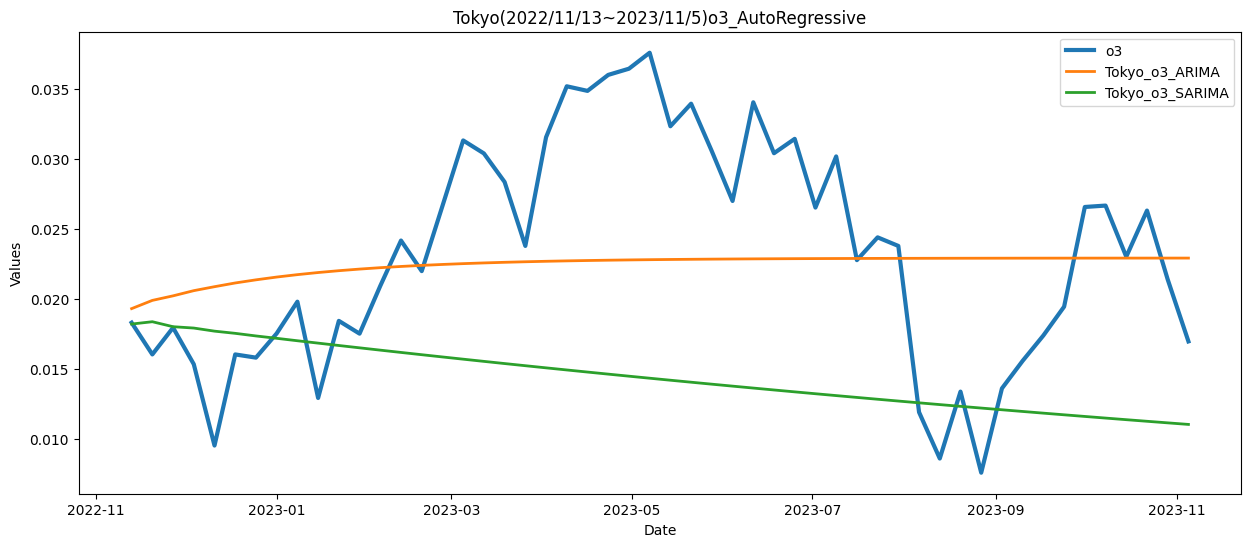

In [ ]:
create_graph(df_pred,Tokyo,"Tokyo",elements)

<ipython-input-74-122c6f929ed8>:10: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, number in pred_df[city_pred].iteritems():
<ipython-input-74-122c6f929ed8>:10: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, number in pred_df[city_pred].iteritems():
<ipython-input-74-122c6f929ed8>:10: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, number in pred_df[city_pred].iteritems():
<ipython-input-74-122c6f929ed8>:10: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, number in pred_df[city_pred].iteritems():
<ipython-input-74-122c6f929ed8>:10: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, number in pred_df[city_pred].iteritems():
<ipython-input-

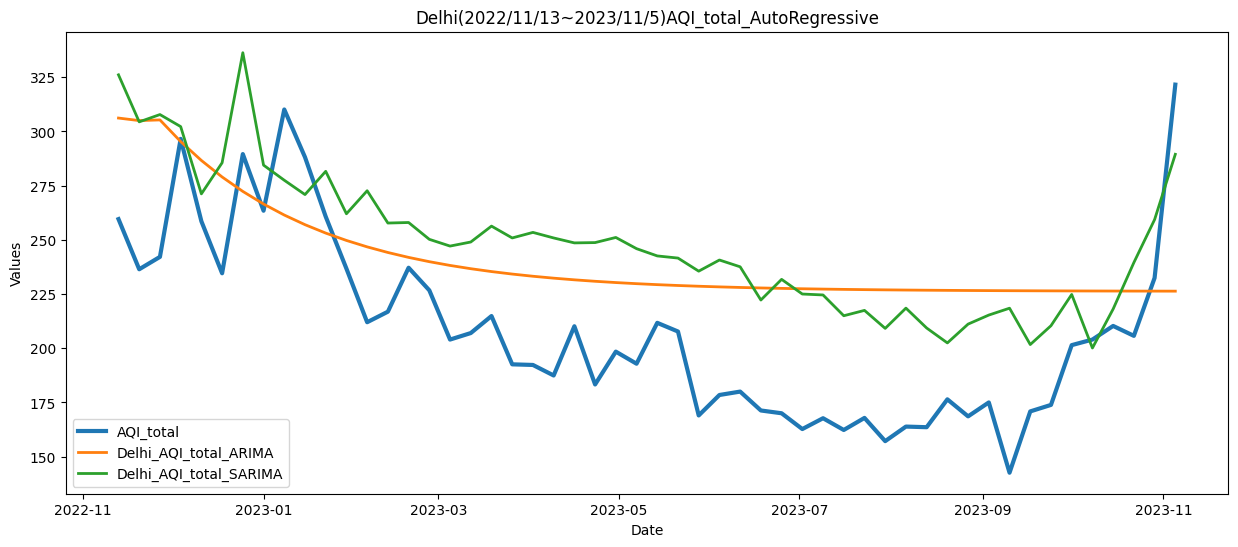

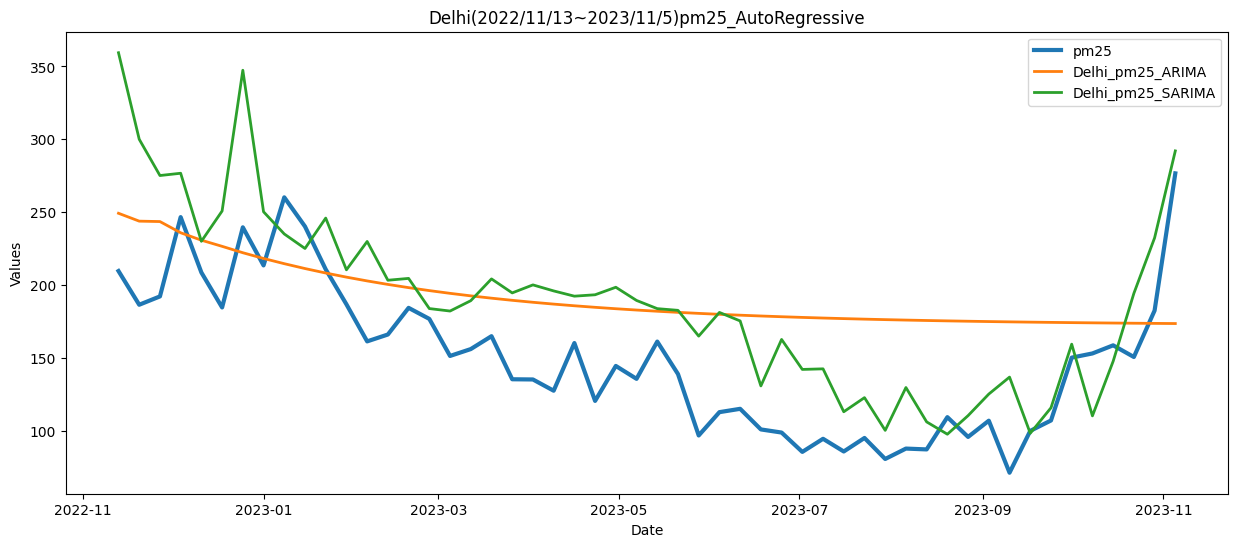

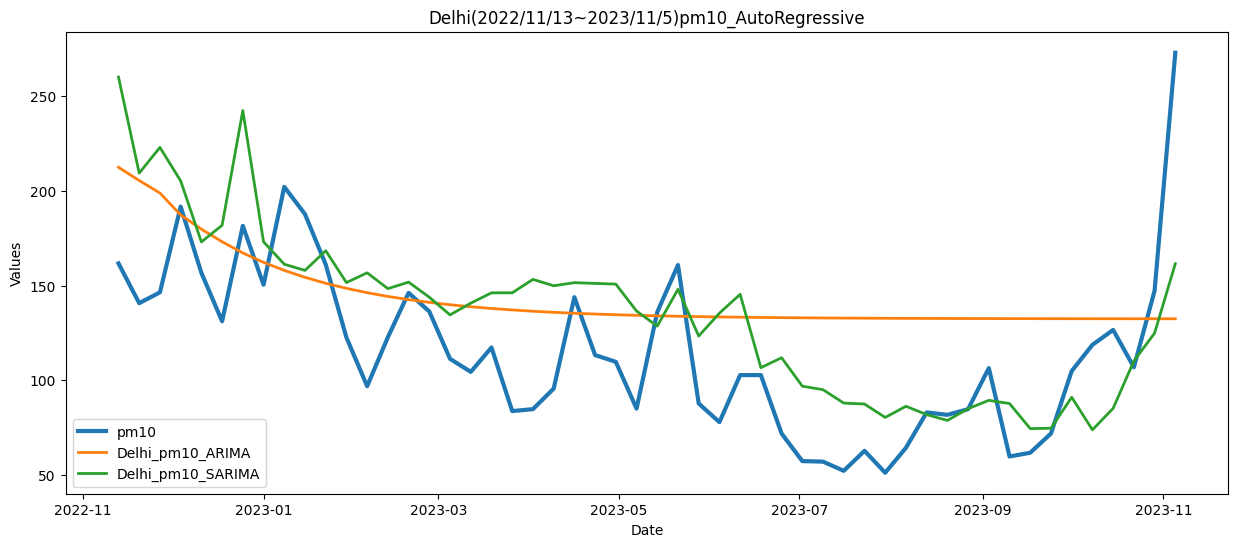

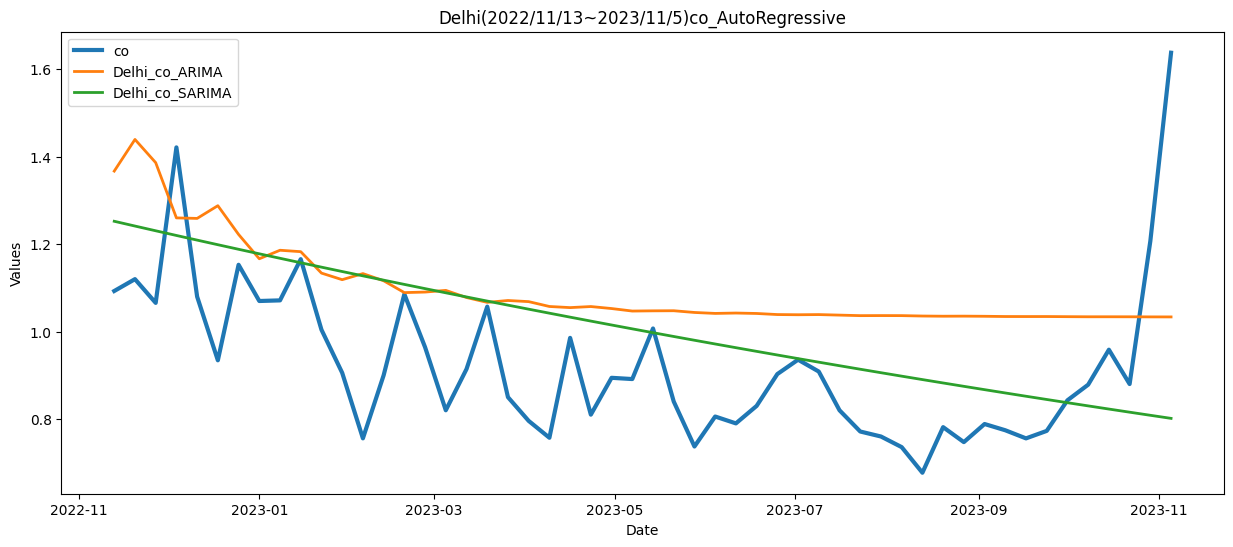

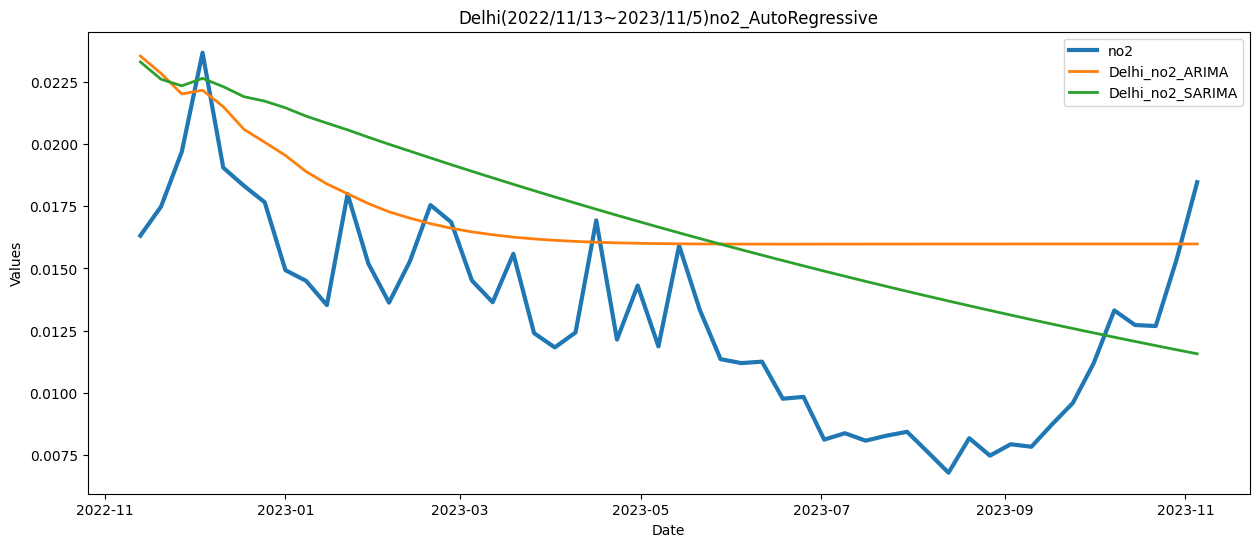

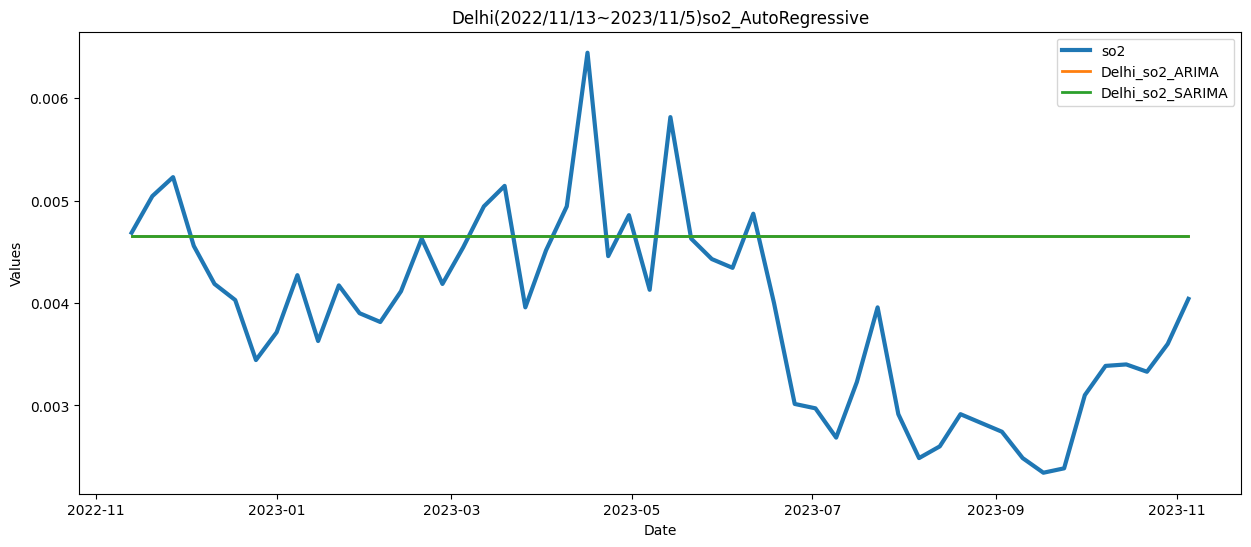

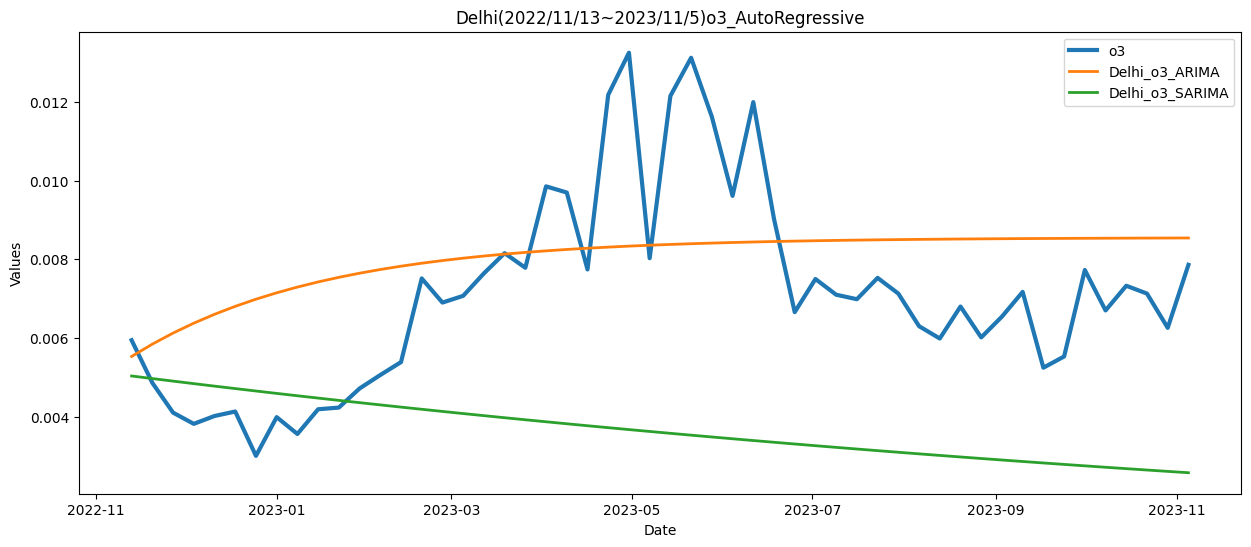

In [ ]:
create_graph(df_pred,Delhi,"Delhi",elements)

# ここから先は動かすのに膨大な時間を要するため、動かさなくてもいい

# SARIMAX

In [16]:
#sarimaxモデルの最適パラメータを求める
def sarimax_parameta(df,city_name,parameta_df):
  para_row = []
  para_row_s = []
  for column_name, item in df[elements].iteritems():
    df_target = df[column_name]
    df_drop = df.drop(columns=column_name)
    for column_name_e, number in df_drop.iteritems():
      train =df_target[:-52]
      test =df_target[-52:]
      exog_train = df_drop[column_name_e][:-52]
      exog_train = df[column_name_e][:-52]
      sarimax_model = pm.auto_arima(train,exog=exog_train,seasonal=True,m=52,n_jobs=1,maxiter=10)
      order = sarimax_model.get_params()['order']
      seasonal_order = sarimax_model.get_params()['seasonal_order']
      para_row.append(order)
      para_row_s.append(seasonal_order)
    print("-----------")

  parameta_df[f"SARIMAX_{city_name}_order"] = para_row
  parameta_df[f"SARIMAX_{city_name}_order_s"] = para_row_s
  return parameta_df

In [37]:
#SARIMAXモデルでパラメータを元に予測する関数
def sarimax_construction(df,city_name,parameta):
  for column_name, number in df[elements].iteritems():
    df_target = df[column_name]
    df_drop = df.drop(columns=column_name)
    for column_name_e, number in df_drop.iteritems():
      train =df[column_name][:-52]
      test =df[column_name][-52:]
      exog_train = df[column_name_e][:-52]
      exog_test = df[column_name_e][-52:]

      ##ここ改良必要
      sarimax_model = sm.tsa.SARIMAX(train,exog=exog_train,order=parameta[f"SARIMAX_{city_name}_order"].loc[f"{column_name}_{column_name_e}"],seasonal_order=(parameta[f"SARIMAX_{city_name}_order_s"].loc[f"{column_name}_{column_name_e}"]),enforce_invertibility = False, enforce_stationarity = False)
      results = sarimax_model.fit()
      bestpred = results.predict(start="2022-11-13",end="2023-11-05",exog=exog_test,dynamic= True)
      df_pred[f"{city_name}_{column_name}_{column_name_e}_SARIMAX"] = bestpred.values
      mape_df = str(str(round(mape(bestpred, test)*100,2))+"%")
      df_results_x.at[f"{city_name}_{column_name}_{column_name_e}","SARIMAX"] = mape_df

  return



### SARIMAXモデルにてTokyoのデータで回す

※ 一つの都市で予測値を算出するのに膨大な時間を要するため、SARIMAXモデルでは都市ごとに予測した値とMAPE値を保存する

In [17]:
#最適なパラメータを求める
%%time
sarimax_parameta(Tokyo,"Tokyo",Tokyo_para_x)

<ipython-input-16-ee57ea6f11c5>:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, item in df[elements].iteritems():
<ipython-input-16-ee57ea6f11c5>:8: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name_e, number in df_drop.iteritems():


-----------


<ipython-input-16-ee57ea6f11c5>:8: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name_e, number in df_drop.iteritems():


-----------


<ipython-input-16-ee57ea6f11c5>:8: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name_e, number in df_drop.iteritems():


-----------


<ipython-input-16-ee57ea6f11c5>:8: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name_e, number in df_drop.iteritems():


-----------


<ipython-input-16-ee57ea6f11c5>:8: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name_e, number in df_drop.iteritems():


-----------


<ipython-input-16-ee57ea6f11c5>:8: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name_e, number in df_drop.iteritems():
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.10/dist-packages/statsmode

-----------


<ipython-input-16-ee57ea6f11c5>:8: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name_e, number in df_drop.iteritems():


-----------
CPU times: user 2h 22min 28s, sys: 1h 12min 45s, total: 3h 35min 14s
Wall time: 2h 7min 55s


,SARIMAX_Tokyo_order,SARIMAX_Tokyo_order_s
AQI_total_precipitation,"(0, 1, 1)","(1, 0, 0, 52)"
AQI_total_temperature,"(0, 1, 1)","(1, 0, 0, 52)"
AQI_total_wind-speed,"(0, 1, 1)","(1, 0, 0, 52)"
AQI_total_pressure,"(0, 1, 1)","(1, 0, 0, 52)"
AQI_total_humidity,"(0, 1, 1)","(1, 0, 0, 52)"
...,...,...
o3_so2,"(2, 0, 0)","(0, 0, 0, 52)"
o3_pm25,"(2, 0, 0)","(0, 0, 0, 52)"
o3_pm10,"(2, 0, 0)","(0, 0, 0, 52)"
o3_no2,"(2, 0, 0)","(0, 0, 0, 52)"


In [ ]:
#説明変数あり(パラメータを保存)
Tokyo_para_x.to_csv(f"{path_para}/Tokyo_explanatory_variables_ARIMAX_SARIMAX.csv")

In [ ]:
#パラメータを元に予測値を出力
sarimax_construction(Tokyo,"Tokyo",Tokyo_para_x)

In [ ]:
#説明変数ありのSRIMAXのMAPE値を保存(Tokyo)
df_results_x.to_csv(f"{path_mape}/自己回帰_explanatory_variables_ARIMAX_SARIMAX_tokyo.csv")

In [ ]:
#予測値のデータフレームを保存(Tokyo)
df_pred.to_csv(f"{pred_path}/ARIMA_SARIMA_ARIMAX_SARIMAX_tokyo.csv")

### SARIMAXモデルにてDelhiのデータで回す

In [36]:
#最適なパラメータを求める
%%time
sarimax_parameta(Delhi,"Delhi",Delhi_para_x)

<ipython-input-34-ee57ea6f11c5>:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, item in df[elements].iteritems():
<ipython-input-34-ee57ea6f11c5>:8: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name_e, number in df_drop.iteritems():


-----------


<ipython-input-34-ee57ea6f11c5>:8: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name_e, number in df_drop.iteritems():


-----------


<ipython-input-34-ee57ea6f11c5>:8: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name_e, number in df_drop.iteritems():


-----------


<ipython-input-34-ee57ea6f11c5>:8: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name_e, number in df_drop.iteritems():


-----------


<ipython-input-34-ee57ea6f11c5>:8: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name_e, number in df_drop.iteritems():


-----------


<ipython-input-34-ee57ea6f11c5>:8: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name_e, number in df_drop.iteritems():
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.10/dist-packages/statsmode

-----------


<ipython-input-34-ee57ea6f11c5>:8: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name_e, number in df_drop.iteritems():


-----------
CPU times: user 3h 17min 52s, sys: 1h 40min 6s, total: 4h 57min 59s
Wall time: 2h 59min 22s


,ARIMAX_Delhi,SARIMAX_Delhi_order,SARIMAX_Delhi_order_s
AQI_total_temperature,"(1, 0, 3)","(4, 0, 0)","(1, 0, 0, 52)"
AQI_total_precipitation,"(1, 0, 3)","(4, 0, 0)","(1, 0, 0, 52)"
AQI_total_humidity,"(1, 0, 3)","(4, 0, 0)","(1, 0, 0, 52)"
AQI_total_pressure,"(1, 0, 3)","(4, 0, 0)","(1, 0, 0, 52)"
AQI_total_co,"(1, 0, 3)","(4, 0, 0)","(1, 0, 0, 52)"
...,...,...,...
o3_so2,"(1, 0, 1)","(1, 0, 1)","(0, 0, 0, 52)"
o3_pm25,"(1, 0, 1)","(1, 0, 1)","(0, 0, 0, 52)"
o3_pm10,"(1, 0, 1)","(1, 0, 1)","(0, 0, 0, 52)"
o3_no2,"(1, 0, 1)","(1, 0, 1)","(0, 0, 0, 52)"


In [ ]:
#デリーのパラメータ保存
Delhi_para_x.to_csv(f"{path_para}/Delhi_explanatory_variables_ARIMAX_SRIMAX.csv")

In [39]:
#パラメータを元に予測値を出力
sarimax_construction(Delhi,"Delhi",Delhi_para_x)

<ipython-input-37-20d5451bf277>:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, number in df[elements].iteritems():
<ipython-input-37-20d5451bf277>:6: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name_e, number in df_drop.iteritems():
<ipython-input-37-20d5451bf277>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pred[f"{city_name}_{column_name}_{column_name_e}_SARIMAX"] = bestpred.values
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipyth

In [43]:
#説明変数ありのARIMAXのMAPE値を保存(Delhi)
df_results_x.to_csv(f"{path_mape}/自己回帰_explanatory_variables_ARIMAX_SARIMAX_delhi.csv")

In [44]:
#予測値のデータフレームを保存(delhi)
df_pred.to_csv(f"{pred_path}/ARIMA_SARIMA_ARIMAX_SARIMAX_delhi.csv")